In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

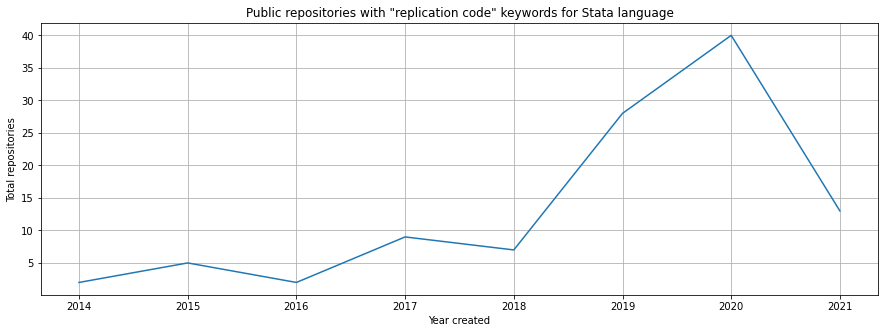

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-04-18 10:08:14: https://www.aeaweb.org/journals/aer/issues
2021-04-18 10:08:16: https://www.aeaweb.org/journals/aeri/issues
2021-04-18 10:08:17: https://www.aeaweb.org/journals/app/issues
2021-04-18 10:08:18: https://www.aeaweb.org/journals/pol/issues
2021-04-18 10:08:19: https://www.aeaweb.org/journals/mac/issues
2021-04-18 10:08:21: https://www.aeaweb.org/journals/mic/issues
2021-04-18 10:08:22: https://www.aeaweb.org/journals/jel/issues
2021-04-18 10:08:23: https://www.aeaweb.org/journals/jep/issues
2021-04-18 10:08:24: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

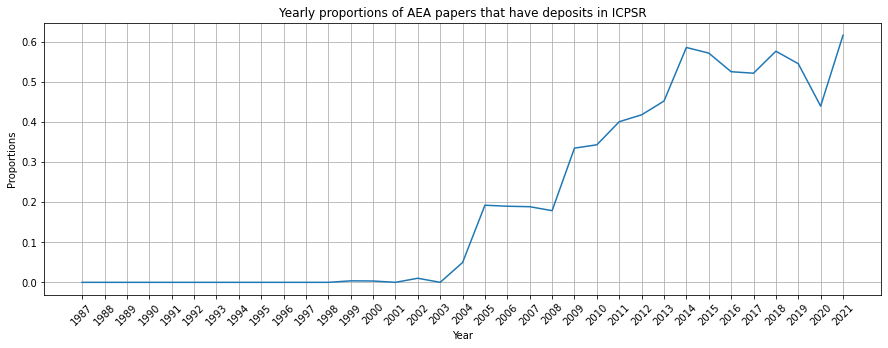

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [9]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review
- Journal of Economic Literature
- Journal of Economic Perspectives

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## Econometrica 

In [14]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-04-18 10:08:28: http://dx.doi.org/10.3982/ecta15213
2021-04-18 10:08:30: http://dx.doi.org/10.3982/ecta16481
2021-04-18 10:08:32: http://dx.doi.org/10.3982/ecta14806
2021-04-18 10:08:34: http://dx.doi.org/10.3982/ecta15011
2021-04-18 10:08:36: http://dx.doi.org/10.3982/ecta16756
2021-04-18 10:08:38: http://dx.doi.org/10.3982/ecta15022
2021-04-18 10:08:40: http://dx.doi.org/10.3982/ecta13333
2021-04-18 10:08:43: http://dx.doi.org/10.3982/ecta14243
2021-04-18 10:08:45: http://dx.doi.org/10.3982/ecta16413
2021-04-18 10:08:47: http://dx.doi.org/10.3982/ecta17477
2021-04-18 10:08:49: http://dx.doi.org/10.3982/ecta14031
2021-04-18 10:08:51: http://dx.doi.org/10.3982/ecta17527
2021-04-18 10:08:53: http://dx.doi.org/10.3982/ecta14269
2021-04-18 10:08:55: http://dx.doi.org/10.3982/ecta15746
2021-04-18 10:08:57: http://dx.doi.org/10.3982/ecta14605
2021-04-18 10:08:59: http://dx.doi.org/10.3982/ecta17950
2021-04-18 10:09:01: http://dx.doi.org/10.3982/ecta15735
2021-04-18 10:09:03: http://dx.

## Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-04-18 10:18:53: http://dx.doi.org/10.1086/588585
2021-04-18 10:18:55: http://dx.doi.org/10.1086/701604
2021-04-18 10:18:57: http://dx.doi.org/10.1086/686747
2021-04-18 10:18:59: http://dx.doi.org/10.1086/712507
2021-04-18 10:19:01: http://dx.doi.org/10.1086/497999
2021-04-18 10:19:04: http://dx.doi.org/10.1086/498585
2021-04-18 10:19:07: http://dx.doi.org/10.1086/709970
2021-04-18 10:19:09: http://dx.doi.org/10.1086/684750
2021-04-18 10:19:11: http://dx.doi.org/10.1086/691450
2021-04-18 10:19:14: http://dx.doi.org/10.1086/697086
2021-04-18 10:19:16: http://dx.doi.org/10.1086/701809
2021-04-18 10:19:18: http://dx.doi.org/10.1086/711953
2021-04-18 10:19:20: http://dx.doi.org/10.1086/674362
2021-04-18 10:19:23: http://dx.doi.org/10.1086/704574
2021-04-18 10:19:25: http://dx.doi.org/10.1086/432166
2021-04-18 10:19:28: http://dx.doi.org/10.1086/511995
2021-04-18 10:19:31: http://dx.doi.org/10.1086/701807
2021-04-18 10:19:33: http://dx.doi.org/10.1086/508033
2021-04-18 10:19:36: http://

## The Quarterly Journal of Economics

In [16]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-04-18 10:41:58: http://dx.doi.org/10.1093/qje/qjv013
2021-04-18 10:42:00: http://dx.doi.org/10.1093/qje/qjx050
2021-04-18 10:42:02: http://dx.doi.org/10.1093/qje/qjt009
2021-04-18 10:42:04: http://dx.doi.org/10.1093/qje/qjv014
2021-04-18 10:42:07: http://dx.doi.org/10.1093/qje/qjr001
2021-04-18 10:42:09: http://dx.doi.org/10.1162/003355303322552793
2021-04-18 10:42:11: http://dx.doi.org/10.1093/qje/qjx036
2021-04-18 10:42:13: http://dx.doi.org/10.1093/qje/qjt012
2021-04-18 10:42:14: http://dx.doi.org/10.1162/003355303321675428
2021-04-18 10:42:16: http://dx.doi.org/10.1093/qje/qjaa007
2021-04-18 10:42:18: http://dx.doi.org/10.1162/003355301753265598
2021-04-18 10:42:19: http://dx.doi.org/10.1162/qjec.2010.125.3.1051
2021-04-18 10:42:22: http://dx.doi.org/10.1093/qje/qjs028
2021-04-18 10:42:23: http://dx.doi.org/10.1093/qje/qjaa010
2021-04-18 10:42:26: http://dx.doi.org/10.1162/0033553041502144
2021-04-18 10:42:28: http://dx.doi.org/10.1093/qje/qjv020
2021-04-18 10:42:30: http://dx

## Journal of Economic Growth 

In [18]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-04-18 10:48:29: http://dx.doi.org/10.1007/s10887-013-9096-y
2021-04-18 10:48:31: http://dx.doi.org/10.1007/s10887-006-7404-5
2021-04-18 10:48:32: http://dx.doi.org/10.1007/s10887-009-9046-x
2021-04-18 10:48:33: http://dx.doi.org/10.1007/s10887-016-9136-5
2021-04-18 10:48:35: http://dx.doi.org/10.1007/s10887-011-9074-1
2021-04-18 10:48:36: http://dx.doi.org/10.1007/s10887-018-9157-3
2021-04-18 10:48:37: http://dx.doi.org/10.1007/s10887-009-9044-z
2021-04-18 10:48:39: http://dx.doi.org/10.1007/s10887-012-9086-5
2021-04-18 10:48:40: http://dx.doi.org/10.1007/s10887-012-9085-6
2021-04-18 10:48:41: http://dx.doi.org/10.1007/s10887-018-9160-8
2021-04-18 10:48:43: http://dx.doi.org/10.1007/s10887-018-09161-z
2021-04-18 10:48:44: http://dx.doi.org/10.1007/s10887-009-9047-9
2021-04-18 10:48:46: http://dx.doi.org/10.1007/s10887-015-9123-2
2021-04-18 10:48:47: http://dx.doi.org/10.1007/s10887-007-9011-5
2021-04-18 10:48:48: http://dx.doi.org/10.1007/s10887-010-9057-7
2021-04-18 10:48:49: htt

## Journal of Finance

In [92]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    import crossref_commons.retrieval
    url = 'https://afajof.org/supplements/'
    res = requests.get(url)
    content = BeautifulSoup(res.content, features='html.parser')
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)